In [1]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np

from dotenv import load_dotenv
load_dotenv()
DATASET_PATH=os.getenv("DATASET_DIRECTORY")
CONFIG_DIRECTORY = os.getenv("CONFIG_DIRECTORY")
RADVEL_MODEL_STATE_DICT_PATH=os.getenv("RADVEL_MODEL_STATE_DICT_PATH")
MODEL_TRAINING_DATASET_PATH=os.getenv("MODEL_TRAINING_DATASET_PATH")
GENERATED_DATASETS_PATH=os.getenv("GENERATED_DATASETS_PATH")


sys.path.append("../")
from mmwave_radar_processing.config_managers.cfgManager import ConfigManager
from cpsl_datasets.cpsl_ds import CpslDS

from mmwave_model_integrator.input_encoders.radvel_encoder import RadVelEncoder
from mmwave_model_integrator.ground_truth_encoders.radvel_gt_encoder import RadVelGTEncoder
from mmwave_model_integrator.plotting.plotter_doppler_az_to_vel import PlotterDopplerAzToVel
from mmwave_model_integrator.dataset_generators.doppler_az_to_vel_dataset_generator import DopplerAzToVelDatasetGenerator

/home/david/.cache/pypoetry/virtualenvs/mmwave-model-integrator-S4Y7oiM5-py3.12/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
#setup the config manager
cfg_manager = ConfigManager()

cfg_path = os.path.join(CONFIG_DIRECTORY,"RadVel.cfg")
cfg_manager.load_cfg(cfg_path)
cfg_manager.compute_radar_perforance(profile_idx=0)

In [3]:
print(cfg_manager.vel_max_m_s)
print(cfg_manager.vel_res_m_s)

1.9085336007130127
0.06361778669043376


In [3]:
#determine the paths to all of the datasets
train_datasets = ["NORTH_RadVel_Test_1"]
train_scenario_folders = [os.path.join(MODEL_TRAINING_DATASET_PATH,dataset) for dataset in train_datasets]

test_datasets = []
test_scenario_folders = [os.path.join(MODEL_TRAINING_DATASET_PATH,dataset) for dataset in test_datasets]

In [ ]:
#initializing the dataset generator
dataset_path = train_scenario_folders[0]
dataset = CpslDS(
    dataset_path=dataset_path,
    radar_folder="radar_0_adc",
    lidar_folder="lidar",
    camera_folder="camera",
    imu_orientation_folder="imu_data",
    imu_full_folder="imu_data_full",
    vehicle_odom_folder="vehicle_odom"
)

/data/RadVel/NORTH_RadVel_Test_1
found 580 radar samples
found 580 lidar samples
found 580 camera samples
did not find imu (orientation) samples
did not find imu (full data) samples
found 580 vehicle velocity samples
found 580 vehicle odometry samples


In [5]:
#initialize the encoder and decoder
input_encoder = RadVelEncoder(
    config_manager=cfg_manager,
    num_angle_bins=64,
    min_power_threshold_dB=40
)

ground_truth_encoder = RadVelGTEncoder()

plotter = PlotterDopplerAzToVel()

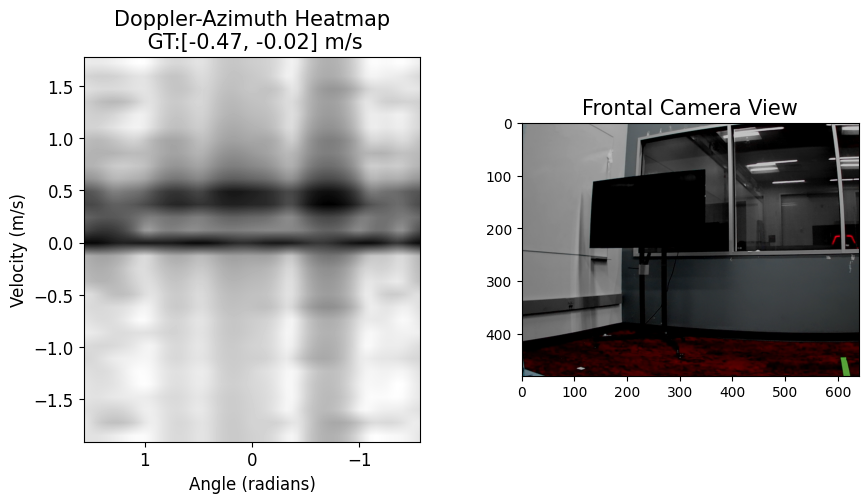

In [6]:
#plot a sample of the input/output for training
idx = 250
adc_cube = dataset.get_radar_data(idx)
odom = dataset.get_vehicle_odom_data(idx)

#get camera data
try:
    camera_view = dataset.get_camera_frame(idx)
except AssertionError:
    camera_view = np.empty(shape=(0))

plotter.plot_compilation(
    input_data=adc_cube,
    input_encoder=input_encoder,
    gt_data=odom,
    ground_truth_encoder=ground_truth_encoder,
    runner=None,
    decoder=None,
    camera_view=camera_view,
    axs=[],
    show=True
)

In [7]:
#initialize the dataset generator
generated_dataset_path = os.path.join(GENERATED_DATASETS_PATH,"RadVel_train")
dataset_generator = DopplerAzToVelDatasetGenerator(
    generated_dataset_path=generated_dataset_path,
    dataset_handler=dataset,
    input_encoder=input_encoder,
    ground_truth_encoder=ground_truth_encoder,
    generated_file_name="frame",
    input_encoding_folder="doppler_az_resps",
    ground_truth_encoding_folder="vels",
    clear_existing_data=True
)

DatasetGenerator._check_for_directory: found directory /home/david/Downloads/generated_datasets/RadVel_train
DatasetGenerator._check_for_directory: clearing contents of /home/david/Downloads/generated_datasets/RadVel_train
DatasetGenerator._check_for_directory: found directory /home/david/Downloads/generated_datasets/RadVel_train/doppler_az_resps
DatasetGenerator._check_for_directory: clearing contents of /home/david/Downloads/generated_datasets/RadVel_train/doppler_az_resps
DatasetGenerator._check_for_directory: found directory /home/david/Downloads/generated_datasets/RadVel_train/vels
DatasetGenerator._check_for_directory: clearing contents of /home/david/Downloads/generated_datasets/RadVel_train/vels


In [8]:
#generate the training dataset
dataset_generator.generate_dataset_from_multiple_scenarios(train_scenario_folders)

Generating data from scenario 0 of 1
found 580 radar samples
found 580 lidar samples
found 580 camera samples
did not find imu (orientation) samples
did not find imu (full data) samples
found 580 vehicle velocity samples
found 580 vehicle odometry samples


 17%|█▋        | 100/579 [00:00<00:01, 327.04it/s]

100%|██████████| 579/579 [00:01<00:00, 319.93it/s]

generated dataset now has 580 samples


In [9]:
#generating the testing dataset
generated_dataset_path = os.path.join(GENERATED_DATASETS_PATH,"RadVel_vel")
dataset_generator.reset(generated_dataset_path)
# dataset_generator.generate_dataset_from_multiple_scenarios(test_scenario_folders)


DatasetGenerator._check_for_directory: found directory /home/david/Downloads/generated_datasets/RadVel_vel
DatasetGenerator._check_for_directory: clearing contents of /home/david/Downloads/generated_datasets/RadVel_vel
DatasetGenerator._check_for_directory: found directory /home/david/Downloads/generated_datasets/RadVel_vel/doppler_az_resps
DatasetGenerator._check_for_directory: clearing contents of /home/david/Downloads/generated_datasets/RadVel_vel/doppler_az_resps
DatasetGenerator._check_for_directory: found directory /home/david/Downloads/generated_datasets/RadVel_vel/vels
DatasetGenerator._check_for_directory: clearing contents of /home/david/Downloads/generated_datasets/RadVel_vel/vels


In [10]:
from mmwave_model_integrator.config import Config
config_path = "../configs/radvel.py"
config = Config(config_path)

config.print_config()

model=dict(
    type=ResNet18Nano,
    n_channels=1,
    n_outputs=2,
),
generated_dataset=dict(
    input_encoding_folder=doppler_az_resps,
    ground_truth_encoding_folder=vels,
    generated_dataset_path=/home/david/Downloads/generated_datasets/RadVel_train,
),
trainer=dict(
    type=_BaseTorchTrainer,
    model=dict(
        type=ResNet18Nano,
        n_channels=1,
        n_outputs=2,
    ),
    optimizer=dict(
        type=Adam,
        lr=0.001,
    ),
    dataset=dict(
        type=DopAzToVelDataset,
        input_transforms=[{'type': 'Resize', 'size': (64, 64)}],
        output_transforms=[],
    ),
    data_loader=dict(
        type=DataLoader,
        batch_size=64,
        shuffle=True,
        num_workers=4,
    ),
    dataset_path=/home/david/Downloads/generated_datasets/RadVel_train,
    input_directory=doppler_az_resps,
    output_directory=vels,
    val_split=0.15,
    working_dir=working_dir,
    save_name=RadVel,
    loss_fn=dict(
        type=RMSELoss,
    ),
    ep

In [11]:
import mmwave_model_integrator.torch_training.trainers as trainers

trainer_config = config.trainer
trainer_class = getattr(trainers,trainer_config.pop('type'))
trainer = trainer_class(**trainer_config)


ModelTrainer: 493 train, 87 val samples loaded
_BaseTorchTrainer._check_for_directory: found directory working_dir


In [12]:
#train the model
trainer.train_model()

ModelTrainer.train: training the network...


  7%|▋         | 1/15 [00:00<00:06,  2.25it/s]

EPOCH: 1/15
	 Train loss: 0.2685799300670624, Val loss:0.5550471544265747


 13%|█▎        | 2/15 [00:00<00:04,  2.91it/s]

EPOCH: 2/15
	 Train loss: 0.15245632827281952, Val loss:0.5867806673049927


 20%|██        | 3/15 [00:00<00:03,  3.24it/s]

EPOCH: 3/15
	 Train loss: 0.1390673965215683, Val loss:0.5228303670883179


 27%|██▋       | 4/15 [00:01<00:03,  3.45it/s]

EPOCH: 4/15
	 Train loss: 0.12555961310863495, Val loss:0.520349383354187


 33%|███▎      | 5/15 [00:01<00:02,  3.55it/s]

EPOCH: 5/15
	 Train loss: 0.10421539098024368, Val loss:0.3676896095275879


 40%|████      | 6/15 [00:01<00:02,  3.66it/s]

EPOCH: 6/15
	 Train loss: 0.08611585199832916, Val loss:0.29912081360816956


 47%|████▋     | 7/15 [00:02<00:02,  3.69it/s]

EPOCH: 7/15
	 Train loss: 0.07634370774030685, Val loss:0.2361958622932434


 53%|█████▎    | 8/15 [00:02<00:01,  3.74it/s]

EPOCH: 8/15
	 Train loss: 0.06971490383148193, Val loss:0.403175950050354


 60%|██████    | 9/15 [00:02<00:01,  3.79it/s]

EPOCH: 9/15
	 Train loss: 0.0796101987361908, Val loss:0.1383069008588791


 67%|██████▋   | 10/15 [00:02<00:01,  3.83it/s]

EPOCH: 10/15
	 Train loss: 0.07161907851696014, Val loss:0.31159624457359314


 73%|███████▎  | 11/15 [00:03<00:01,  3.84it/s]

EPOCH: 11/15
	 Train loss: 0.07140236347913742, Val loss:0.34782105684280396


 80%|████████  | 12/15 [00:03<00:00,  3.83it/s]

EPOCH: 12/15
	 Train loss: 0.06453092396259308, Val loss:0.1898868978023529


 87%|████████▋ | 13/15 [00:03<00:00,  3.84it/s]

EPOCH: 13/15
	 Train loss: 0.06107708066701889, Val loss:0.11454813927412033


 93%|█████████▎| 14/15 [00:03<00:00,  3.87it/s]

EPOCH: 14/15
	 Train loss: 0.0607413575053215, Val loss:0.1718837320804596


100%|██████████| 15/15 [00:04<00:00,  3.66it/s]

EPOCH: 15/15
	 Train loss: 0.06734471768140793, Val loss:0.27412205934524536
ModelTrainer.train: total training time 4.11
